In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72

# Define Physical Domain
xratio = 0.5 # unit: angstrom
xavg = 1.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [6]:
k_ref = 247.15
V_eq = harmonic_well_k_mean(xref, k_ref, xavg)
D = 500 # Diffusion coefficient, unit: s-1
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq;

### Part 3: Read Trajectory

#### physical parameters about simulations

In [7]:
# physical parameters
save_freq = 1e-7 # unit: None, Save trajectory per  ps
total_times = 10e-4 # unit: None, totol simulate time
dt = 1e-9 # unit: s  # Integration Times
#kbT = 1
D = 500. # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [8]:
# Read simulated trajectory from jld file
f_in = "../trajectory/singlewell_unitless.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = float(load(f_in, "D"));

### Part 4: Do KDE and plot

In [30]:
k_eq = 50 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
peq_kde_estimate = gaussian_kde(xref, y_record, sigma_by_keq, w0);

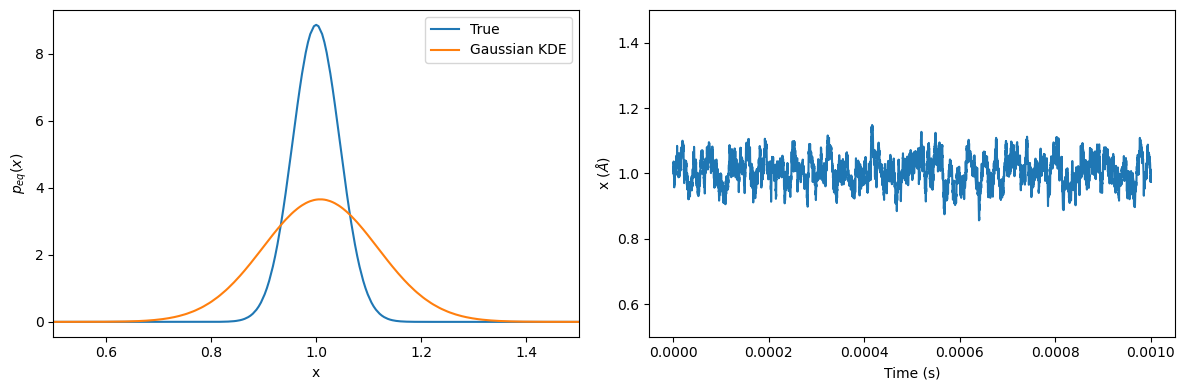

In [31]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq, label="True")
#label = @sprintf "Gaussian KDE: \$\\sigma= %1.2E \$" sigma_by_keq
ax.plot(xref, peq_kde_estimate, label="Gaussian KDE")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.set_xlim(0.5, 1.5)
ax.legend()


ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(0.5, 1.5)

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

### Part : EM-1

In [32]:
n_iteration = 20
k_photon = 100.
p_container = zeros(Float64, n_iteration+1, N)
log_likelihood_records = zeros(n_iteration+1)
        
# Iteration of EM
p_prev = max.(peq_kde_estimate, 1e-10)  # initial guess
p_container[1, :] = max.(peq_kde_estimate, 1e-10) # The first row in container is p0
for iter_id = 1:n_iteration
    println(@sprintf "Iteration-ID: %d" iter_id)
    p_em, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, p_prev, D, Nv, tau, y_record, save_freq, k_photon)
    p_em = max.(p_em, 1e-10)   
    p_container[iter_id+1, :] = p_em    
    p_prev[:,1] = p_em
    log_likelihood_records[iter_id] = log_likelihood
end

Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Iteration-ID: 4
Iteration-ID: 5
Iteration-ID: 6
Iteration-ID: 7
Iteration-ID: 8
Iteration-ID: 9
Iteration-ID: 10
Iteration-ID: 11
Iteration-ID: 12
Iteration-ID: 13
Iteration-ID: 14
Iteration-ID: 15
Iteration-ID: 16
Iteration-ID: 17
Iteration-ID: 18
Iteration-ID: 19
Iteration-ID: 20


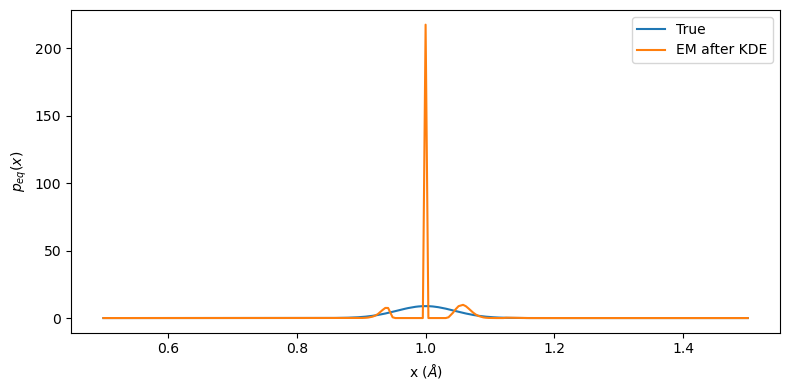

In [33]:
em_id_sele = 20

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, p_container[em_id_sele, :], label="EM after KDE")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

plt.tight_layout()
plt.show()

### Part 5: Forward Algorithm

In [7]:
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq_kde_estimate, D, Nv)
weight_Qx = get_weight_Qx(N, Nv, w0, Qx)
alpha_mat, beta_mat, Anorm_vec = get_mat_vec_v0(Nv, tau)

alpha_t0 = get_alpha_t0(weight_Qx, rho)
beta_t_tau = get_beta_t_tau(w0, rho, Qx, Nv)
atemp = alpha_t0
btemp = beta_t_tau

Anorm_vec[1] = norm(alpha_t0);

In [8]:
alpha_mat, Anorm_vec, atemp = forward_v0(alpha_mat, atemp, tau, y_record, Lambdas, Qx, dt, xref, e_norm, interpo_xs, Np, w0, Anorm_vec)
Anorm_vec[tau+2] = sum(btemp .* atemp)
atemp = atemp ./ Anorm_vec[end]
log_likelihood = sum(log.(Anorm_vec)); # Eq. (41)

### Part 6: Backward Algorithm

In [17]:
LQ_diff_ij = get_LQ_diff_ij(Nv, Lambdas) # Eq. (63) in JPCB 2013

expLQDT = exp.(-Lambdas .* dt)
someones = ones(1,Nv)
eLQDT = expLQDT * someones

beta_mat[:, end] = btemp
exp_ab_mat = zeros(Nv,Nv);

In [18]:
beta_idx = 1
y = y_record[beta_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)

psi_photon_psi = Qx' * photon_mat * Qx
btemp = psi_photon_psi * btemp
        
# Eq. (64) and Eq. (63)
outer= alpha_mat[:, beta_idx] * btemp'
exp_ab_mat = exp_ab_mat .+ outer .* ( diagm(expLQDT * dt) + LQ_diff_ij .* (eLQDT-eLQDT'))
        
btemp = expLQDT .* btemp
btemp = btemp / Anorm_vec[beta_idx]
beta_mat[:, beta_idx] = btemp;

In [12]:
for beta_idx in tau:-1:1
    y = y_record[beta_idx+1]
    photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)

    psi_photon_psi = Qx' * photon_mat * Qx
    btemp = psi_photon_psi * btemp
        
    # Eq. (64) and Eq. (63)
    outer= alpha_mat[:, beta_idx] * btemp'
    exp_ab_mat = exp_ab_mat .+ outer .* ( diagm(expLQDT * dt) + LQ_diff_ij .* (eLQDT-eLQDT'))
        
    btemp = expLQDT .* btemp
    btemp = btemp / Anorm_vec[beta_idx]
    beta_mat[:, beta_idx] = btemp
end

In [15]:
exp_ab_mat = backward_v0(Lambdas, dt, Nv, beta_mat, btemp, tau, y_record, alpha_mat, xref, e_norm, interpo_xs, Np, w0, Qx, Anorm_vec)

# Eq. (72) and Eq. (78)
peq_new = diag(Qx * exp_ab_mat * Qx')
peq_new_normalize = peq_new ./ sum(w0 .* peq_new);

### Part 6: EM-1

In [24]:
peq_kde_estimate = max.(peq_kde_estimate, 1e-10)
p_em_1, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, peq_kde_estimate, D, Nv, tau, y_record, save_freq);

LoadError: MethodError: no method matching forward_backward_v2(::Int64, ::Int64, ::Float64, ::Float64, ::Array{Float64,2}, ::Float64, ::Int64, ::Int64, ::Array{Float64,2}, ::Float64)
Closest candidates are:
  forward_backward_v2(::Int64, ::Int64, !Matched::Int64, !Matched::Int64, ::Array{Float64,2}, ::Float64, ::Int64, ::Int64, ::Array{Float64,2}, ::Float64) at /home/yizaochen/codes/julia/Alphabeta/src/forwardbackward.jl:331

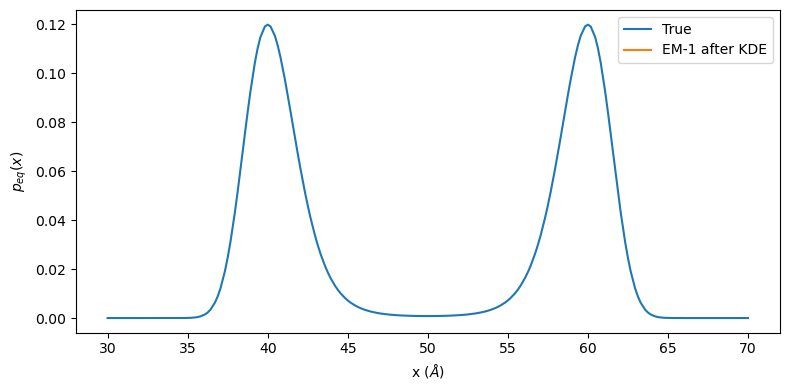

In [68]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, p_em_1, label="EM-1 after KDE")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

plt.tight_layout()
plt.show()